In [3]:
%load_ext autoreload
%autoreload 2

import re

import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Columns statistics

In [193]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [194]:
train_df[['text']].describe()

,text
count,7613
unique,7503
top,11-Year-Old Boy Charged With Manslaughter of T...
freq,10


## Preprocessing stats

In [195]:
# TODO to consider
# stopwords removal
# punctuation removal
# tokenization verification

EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)

train_df[:3]

,id,keyword,location,text,target,text_preproc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...


In [196]:
test_df['text_preproc'] = test_df['text'].apply(_preprocessing)

test_df[:3]

,id,keyword,location,text,text_preproc
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...


In [197]:
def _count(txt: str) -> int:
    return len(txt.split(' '))

train_df['text_length'] = train_df['text'].apply(_count)
test_df['text_length'] = test_df['text'].apply(_count)

train_df[:3]

,id,keyword,location,text,target,text_preproc,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,22


In [198]:
train_positive = train_df.loc[train_df['target'] == 1]
train_negative = train_df.loc[train_df['target'] == 0]

len(train_positive), len(train_negative)

(3271, 4342)

In [199]:
def _count_occurrences(data:str, field: str) -> str:
    results = {}
    for t in data.itertuples():
        l = getattr(t, field)
        if t.text_length in results:
            results[l] += 1
        else:
            results[l] = 0
    return results

positive_lengths = _count_occurrences(train_positive, 'text_length')
negative_lengths = _count_occurrences(train_negative, 'text_length')
test_lengths = _count_occurrences(test_df, 'text_length')

count    3271.000000
mean       15.201162
std         5.184417
min         2.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: text_length, dtype: float64
count    4342.000000
mean       14.723860
std         6.188171
min         1.000000
25%        10.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length, dtype: float64


Text(0.5, 0.98, 'Text lengths')

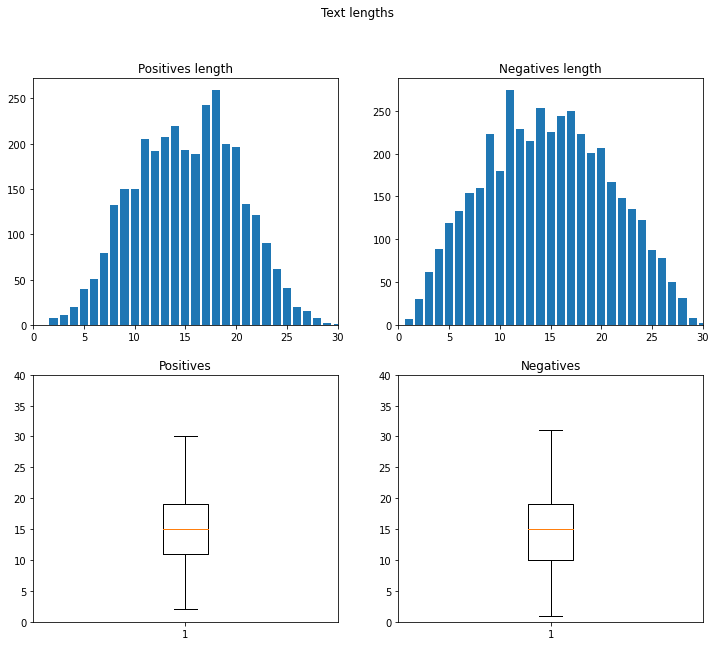

In [200]:
positive_names = list(positive_lengths.keys())
positive_values = list(positive_lengths.values())

negative_names = list(negative_lengths.keys())
negative_values = list(negative_lengths.values())

negatives_df = train_df.loc[train_df['target'] == 0]
positives_df = train_df.loc[train_df['target'] == 1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
ax1.set_title('Positives length')
ax1.set_xlim([0, 30])
ax1.bar(positive_names, positive_values)
ax2.set_title('Negatives length')
ax2.set_xlim([0, 30])
ax2.bar(negative_names, negative_values)

ax3.set_title('Positives')
ax3.set_ylim([0, 40])
ax3.boxplot(positives_df['text_length'])
print(positives_df['text_length'].describe())

ax4.set_title('Negatives')
ax4.set_ylim([0, 40])
ax4.boxplot(negatives_df['text_length'])
print(negatives_df['text_length'].describe())

fig.suptitle('Text lengths')

### Tokens distribution in 2d space

count    3263.000000
mean       14.978854
std         5.814619
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        34.000000
Name: text_length, dtype: float64


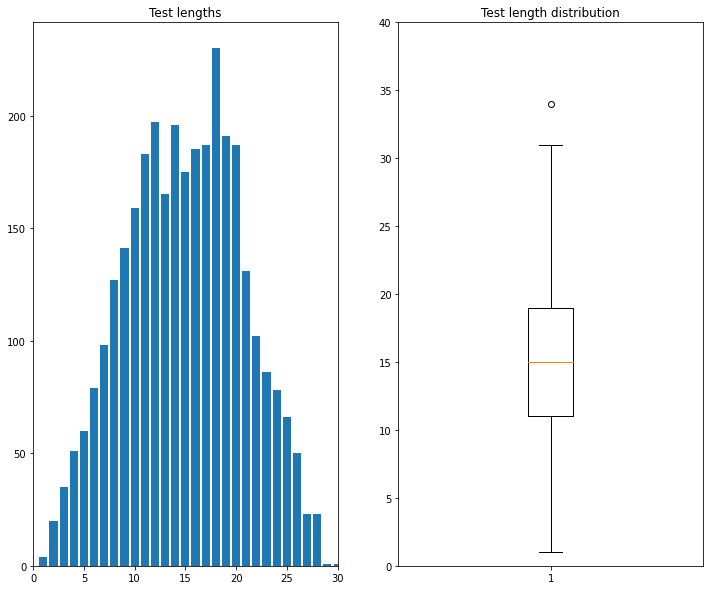

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.set_title('Test lengths')
ax1.set_xlim([0, 30])
ax1.bar(list(test_lengths.keys()), list(test_lengths.values()))

ax2.set_title('Test length distribution')
ax2.set_ylim([0, 40])
ax2.boxplot(test_df['text_length'])

print(test_df['text_length'].describe())

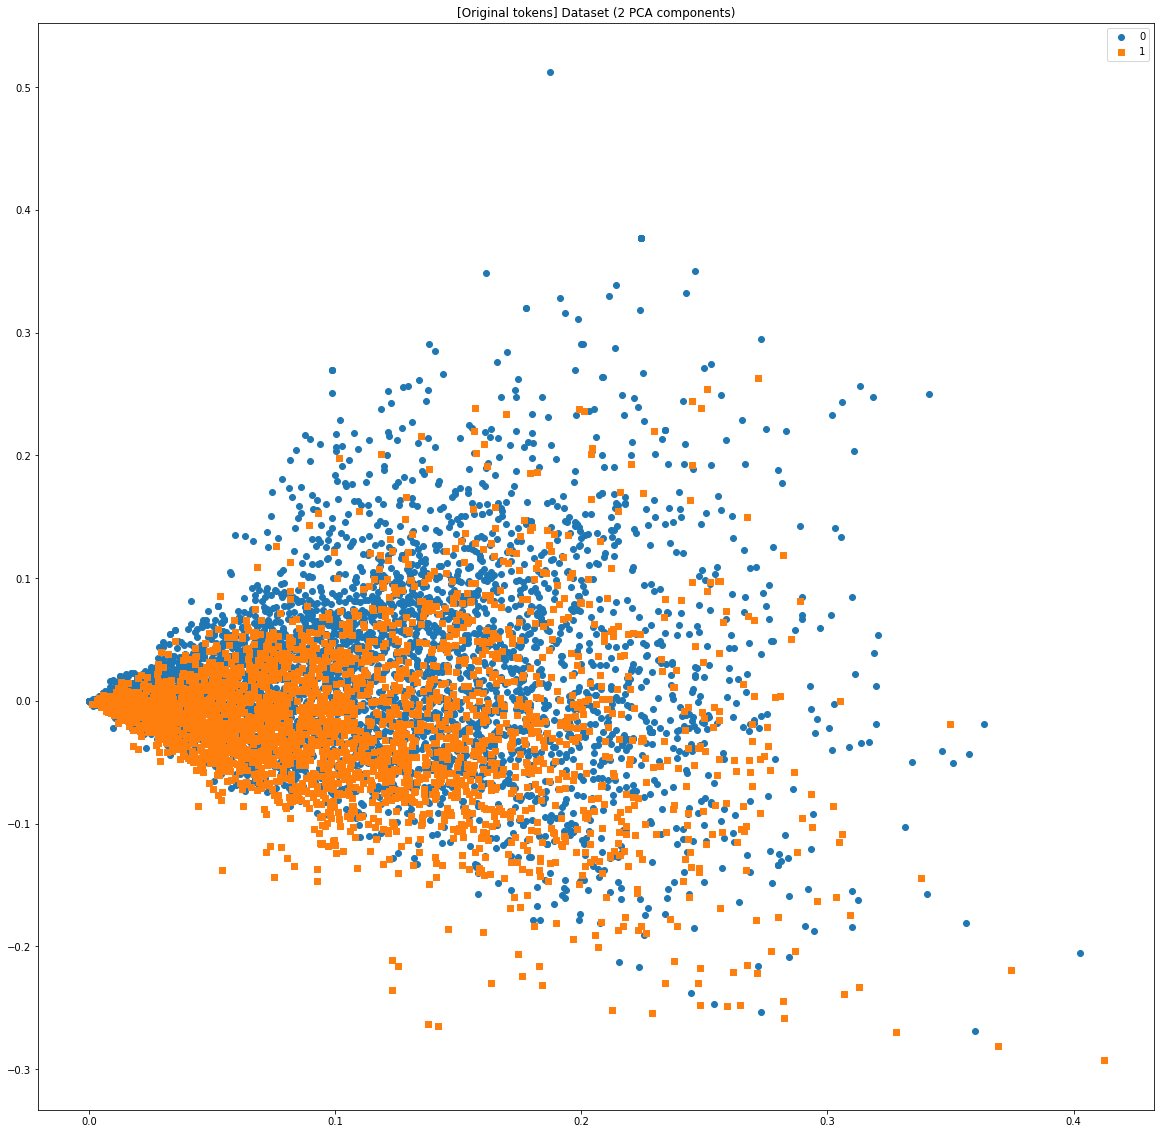

In [202]:
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.gcf().set_size_inches((20, 20))
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

X = train_df['text_preproc']
y = train_df['target']

vec = TfidfVectorizer(min_df=2, max_df=0.4)
vec.fit(X)
X_vec = vec.transform(X)

sgd = TruncatedSVD (n_components=2)
X = sgd.fit_transform(X_vec)

plot_2d_space(X, y, '[Original tokens] Dataset (2 PCA components)')

In [203]:
nlp = spacy.load('en_core_web_sm')
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x23937241cc0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x2393a86c900>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x2393a8ddf40>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x2393a2e8640>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x2393a907d00>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x2393a846e80>)]

In [204]:
# disable not used parts of pipeline

def _lemma(txt: str) -> str:
    return ' '.join([d.lemma_ for d in nlp(txt)])

train_df['text_preproc_lemma'] = train_df['text_preproc'].apply(_lemma)
test_df['text_preproc_lemma'] = test_df['text_preproc'].apply(_lemma)

train_df['text_preproc_lemma']

0       our deed be the reason of this earthquake may ...
1                   forest fire near la ronge sask canada
2       all resident ask to shelter in place be be not...
3         people receive wildfire evacuation order in ...
4       just got send this photo from ruby alaska as s...
                              ...                        
7608    two giant crane hold a bridge collapse into ne...
7609    ariaahrary thetawniest the out of control wild...
7610       m   utckm s of volcano hawaii httptcozdtoydebj
7611    police investigate after an ebike collide with...
7612    the late more home raze by northern california...
Name: text_preproc_lemma, Length: 7613, dtype: object

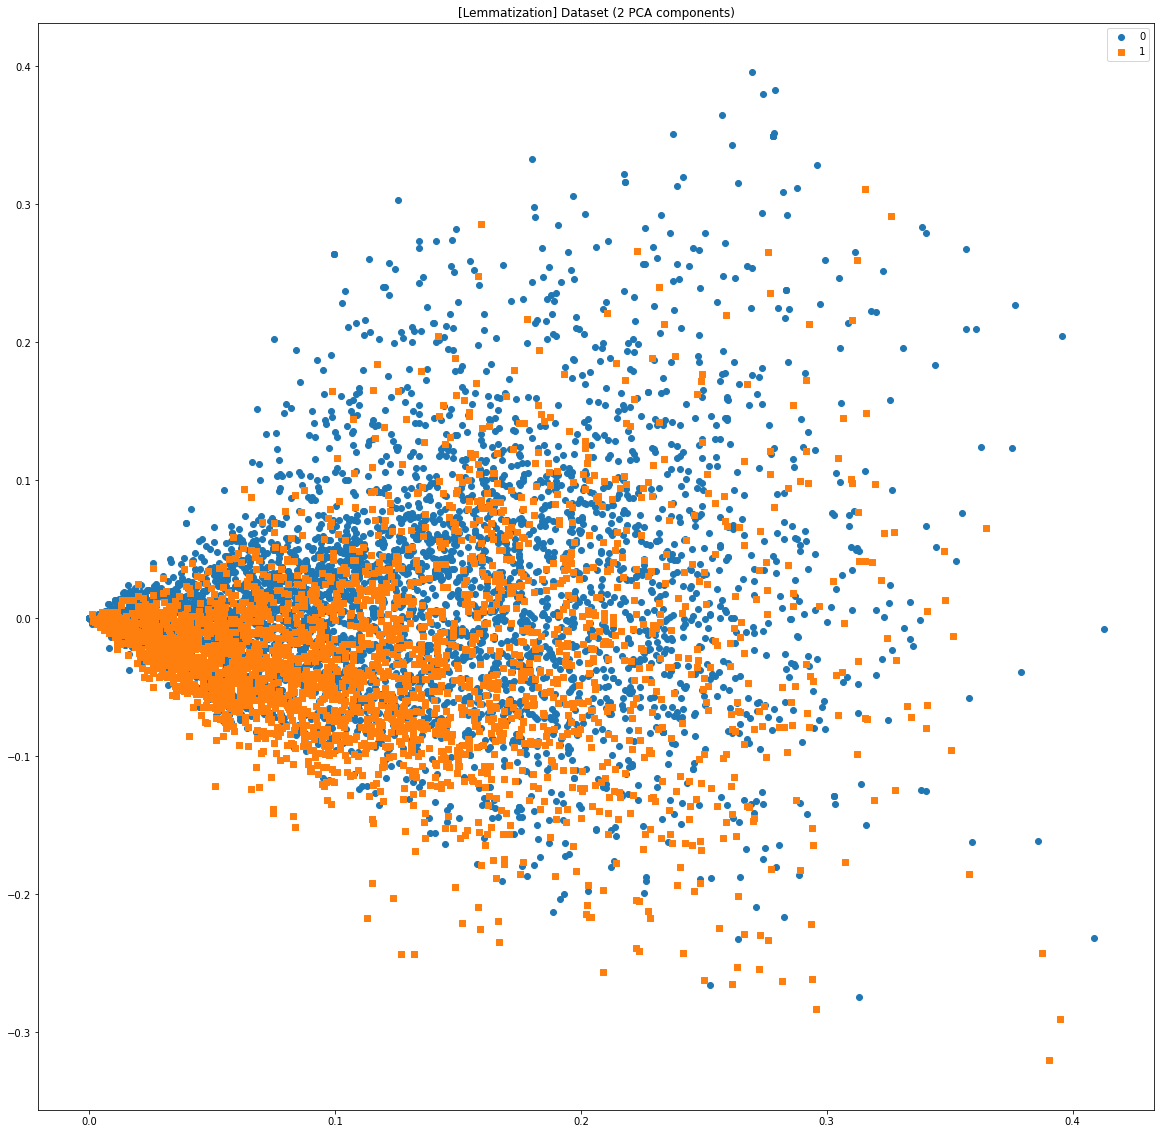

In [205]:
X = train_df['text_preproc_lemma']
y = train_df['target']

vec = TfidfVectorizer(min_df=2, max_df=0.4)
vec.fit(X)
X_vec = vec.transform(X)

sgd = TruncatedSVD (n_components=2)
X = sgd.fit_transform(X_vec)

plot_2d_space(X, y, '[Lemmatization] Dataset (2 PCA components)')

### Tokens saturation from training set in test set

In [213]:
for field in ['text_preproc', 'text_preproc_lemma']:

    X_train = train_df[field]
    X_test = test_df[field]

    vec_train = TfidfVectorizer(min_df=2, max_df=0.4)
    vec_train.fit(X_train)

    vec_test = TfidfVectorizer(min_df=2, max_df=0.4)
    vec_test.fit(X_test)

    # number of common tokens between training and test set
    tokens_train = set(vec_train.get_feature_names())
    tokens_test = set(vec_test.get_feature_names())
    intersection = tokens_train & tokens_test

    print(f'[{field}] Tokens from training set={len(tokens_train)}, tokens from test set={len(tokens_test)}')
    print (f'[{field}] Same tokens={len(intersection)}, '
           f'saturation={len(intersection) / len(set(vec_train.get_feature_names()))}')

[text_preproc] Tokens from training set=6416, tokens from test set=3695
[text_preproc] Same tokens=3097, saturation=0.48269950124688277
[text_preproc_lemma] Tokens from training set=5423, tokens from test set=3231
[text_preproc_lemma] Same tokens=2719, saturation=0.501382998340402


In [ ]:
### Duplicates in training set

In [42]:
targets_df = train_df.groupby('text').nunique().sort_values(by='target', ascending=False)
targets_df[targets_df['target'] > 1]

,id,keyword,location,target
text,,,,
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2,2,1,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2,1,1,2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6,1,1,2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,2,1,2,2
To fight bioterrorism sir.,4,1,0,2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,3,1,0,2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,3,1,2,2
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,3,1,3,2
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6,1,2,2


In [43]:
mismatched_texts = list(targets_df[targets_df['target'] > 1].index)
mismatched_texts

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [44]:
print(len(train_df))

train_df = train_df[~train_df['text'].isin(mismatched_texts)]

print(len(train_df))


7613
7558
